# 確率的な系に関するフィードバック制御に関する検討

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

In [2]:
A = [-0.2 0.4 -1.0 -0.4;
    -0.7 -0.8 -0.6 -0.3;
    -0.2 0.1 -0.2 0.4;
    -0.6 0.8 -0.9 0.3]
B = [-0.2 0.1;
    -0.7 -0.6;
    0.6 0.9;
    -0.4 0.4]
C = [0.8 0.8 -0.8 -0.9;
    -0.7 0.8 -0.8 -0.2]

2×4 Matrix{Float64}:
  0.8  0.8  -0.8  -0.9
 -0.7  0.8  -0.8  -0.2

## 安定化を達成するゲイン行列

$K$を次のように取ると確かに$A + B K C$の固有値の実部はすべて負になる(文献「深層展開による出力フィードバック安定化の検討」小林他(2019)に基づく)

In [3]:
K = [-2.7 2.7;
    2.7 -2.7]

2×2 Matrix{Float64}:
 -2.7   2.7
  2.7  -2.7

確かに$A + B K C$の固有値の実部はたしかに全て負になっている

In [4]:
T = 50.0
N = 1000
η = T/N
mbs = 100
std = 0.4
ub = 3.0

3.0

### SDEを解く


In [5]:
function EM(K, T)
    η = T/N
    x = ones(4,mbs)
    for i in 1:N
        x = x + η*(A + B*K*C)*x + std*sqrt(η)*randn(4,mbs)
    end
    s = sqrt.(sum(x.^2, dims=1))
    ave = sum(s)/mbs
    stdv = sqrt(sum((s .- ave).^2)/mbs)
    return ave, stdv
end        

EM (generic function with 1 method)

### 計算結果の表示

In [6]:
max_itr = 40
AVE = zeros(max_itr)
STDV = zeros(max_itr)
Trange = zeros(max_itr)

for i in 1:max_itr
    Trange[i] = 0.5*i
    ave, stdv = EM(K, 0.5*i)
    AVE[i] = ave
    STDV[i] = stdv
end

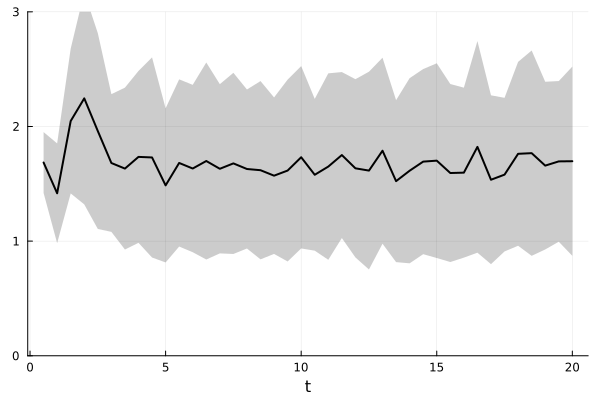

In [7]:
p1 = plot(Trange, AVE, ribbon=STDV, lw=2, legend=false, xlabel="t", ylims=[0,ub],color=:black, fillalpha=0.2)

### DU-EM法

In [8]:
function DU_EM(K, T)
    η = T/N
    x = randn(4,mbs)
    for i in 1:N
        x = x + η*(A + B*K*C)*x + std*sqrt(η)*randn(4,mbs)
    end
    s = sum(x.^2)
    return s
end        

DU_EM (generic function with 1 method)

### 学習プロセス

In [9]:
opt = Flux.ADAM(1.0) 
train_itr = 100
K_train = K
ps = Flux.params(K_train)
for i in 1:train_itr
    gs = Flux.gradient(ps) do
        DU_EM(K_train, 20)
    end
    Flux.Optimise.update!(opt, ps, gs)
end

### 結果の表示

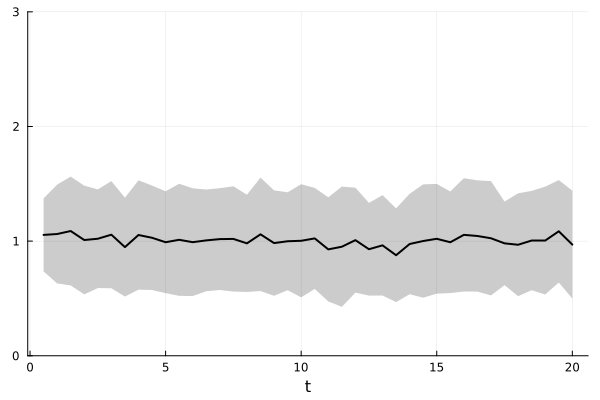

In [10]:
max_itr = 40
AVE = zeros(max_itr)
STDV = zeros(max_itr)
Trange = zeros(max_itr)

for i in 1:max_itr
    Trange[i] = 0.5*i
    ave, stdv = EM(K_train, 0.5*i)
    AVE[i] = ave
    STDV[i] = stdv
end
p2 = plot(Trange, AVE, ribbon=STDV, lw=2, xlabel="t", legend=false,ylims=[0,ub], color=:black, fillalpha=0.2)

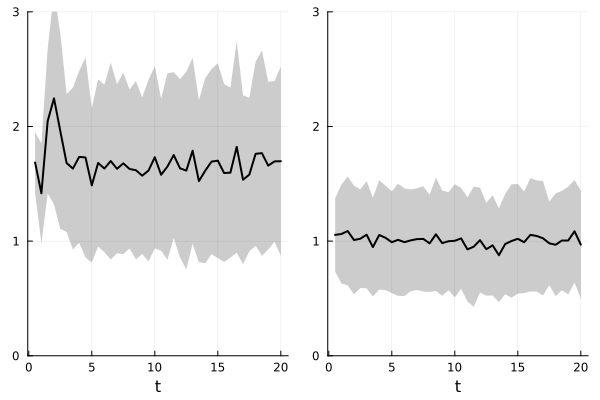

In [11]:
plot(p1,p2)

In [12]:
savefig("DU-stabilize-SDE.pdf")